## 5x5 Grid World
### Q Learning 을 적용하여 5x5 Grid World 에 대한 value function 및 policy 를 구하라.

### GridWorld class

In [9]:
import numpy as np
import common.gridworld5_render as render_helper

class GridWorld:
    def __init__(self):
        self.action_space = [0, 1, 2, 3]  # 행동 공간(가능한 행동들)
        self.action_meaning = {  # 행동의 의미
            0: "UP",
            1: "DOWN",
            2: "LEFT",
            3: "RIGHT",
        }

        self.reward_map = np.array(  # 보상 맵(각 좌표의 보상 값)
            [[0, 0, 0, -1.0, 1.0],
             [0, 0, 0, 0, 0],
             [0, None, None, 0, 0],
             [0, 0, 0, 0, -1.0],
             [0, 0, 0, 0, 0]
             ]
        )

        self.goal_state = (0, 4)    # 목표 상태(좌표)
        self.wall_state = [(2, 1), (2,2)]   # 2,1 2,2 # 벽 상태(좌표)
        self.start_state = (4, 0)   # 시작 상태(좌표)
        self.agent_state = self.start_state   # 에이전트 초기 상태(좌표)

    @property
    def height(self):
        return len(self.reward_map)

    @property
    def width(self):
        return len(self.reward_map[0])

    @property
    def shape(self):
        return self.reward_map.shape

    def actions(self):
        return self.action_space

    def states(self):
        for h in range(self.height):
            for w in range(self.width):
                yield (h, w)

    def next_state(self, state, action):
        # 이동 위치 계산
        action_move_map = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        move = action_move_map[action]
        next_state = (state[0] + move[0], state[1] + move[1])
        ny, nx = next_state

        # 이동한 위치가 그리드 월드의 테두리 밖이나 벽인가?
        if nx < 0 or nx >= self.width or ny < 0 or ny >= self.height:
            next_state = state
        elif next_state == self.wall_state[0] or next_state == self.wall_state[1]:
            next_state = state

        return next_state  # 다음 상태 반환

    def reward(self, state, action, next_state):
        if self.reward_map[next_state] == None:
            return 0

        return self.reward_map[next_state]

    def reset(self):
        self.agent_state = self.start_state
        return self.agent_state

    def step(self, action):
        state = self.agent_state
        next_state = self.next_state(state, action)
        reward = self.reward(state, action, next_state)
        done = (next_state == self.goal_state)

        self.agent_state = next_state
        return next_state, reward, done

    def render_v(self, v=None, policy=None, print_value=True):
        renderer = render_helper.Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_v(v, policy, print_value)

    def render_q(self, q=None, print_value=True):
        renderer = render_helper.Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_q(q, print_value)


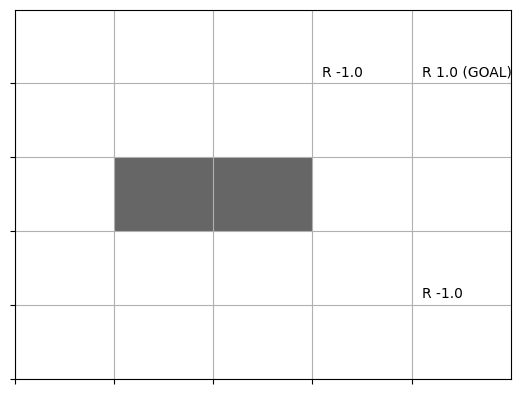

In [10]:
env = GridWorld()

env = GridWorld()
env.render_v()

### Policy Evaluation

In [11]:
from collections import defaultdict
import numpy as np
from common.utils import greedy_probs

class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        random_actions = {0:0.25, 1:0.25, 2:0.25, 3:0.25}
        self.b = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)

    def get_action(self, state):
        action_probs = self.b[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def update(self, state, action, reward, next_state, done):
        if done:
            next_q_max = 0
        else:
            next_qs = [self.Q[next_state, a] for a in range(self.action_size)]
            next_q_max = max(next_qs)

        target = reward + self.gamma * next_q_max
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha

        self.b[state] = greedy_probs(self.Q, state, epsilon=self.epsilon)

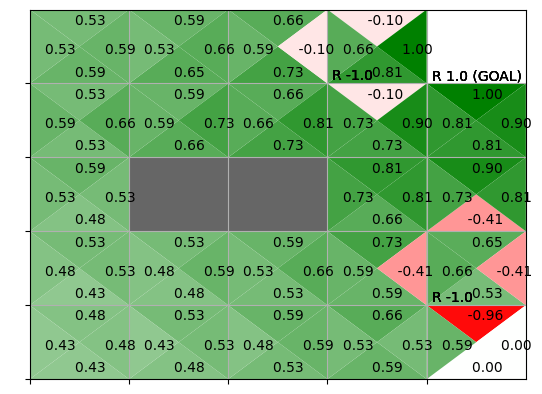

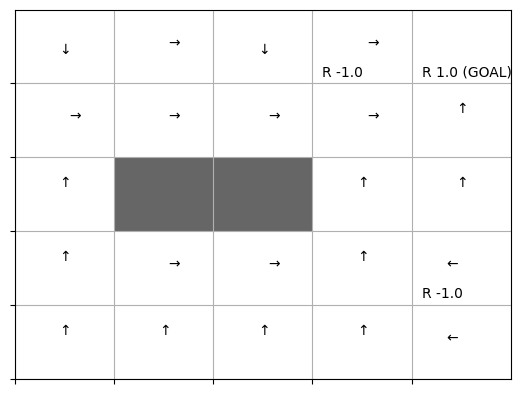

In [12]:
env = GridWorld()
agent = QLearningAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    #agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, next_state, done)

        if done:
            break
        state = next_state

env.render_q(agent.Q)